# Disciple - 取引シミュレーション（Jupyter用）

In [1]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import get_trend_footer, load_setting
from funcs.tide import get_date_dir_from_file, get_date_str_from_file_2
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [22]:
debug = False

res = AppRes()
excel = "ticks_20260204.xlsx"
#code = "285A"
# code = "4689"
#code = "7011"
#code = "7203"
# code = "8306"
code = "8410"
# code = "9984"

dict_ts = dict()
dict_ts["datetime_str_2"] = get_date_str_from_file_2(excel)
dict_setting = load_setting(res, code)
title_str = get_trend_footer(dict_ts, dict_setting)

date_str = get_date_dir_from_file(excel)
print(date_str)

if debug:
    output_dir = os.path.join("tmp", date_str)
else:
    output_dir = os.path.join(res.dir_output, date_str)
print(output_dir)
os.makedirs(output_dir, exist_ok=True)

app = Disciple(excel, code, dict_setting)
app.run()

2026\02\04
output\2026\02\04
パラメータ
PERIOD_WARMUP : 30
PERIOD_MA_1 : 30
LOSSCUT_1 : -5.0
N_MINUS_MAX : 150
DD_PROFIT : 1.0
DD_RATIO : 0.5


In [23]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [24]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts  price   volume        vwap         ma1  \
2026-02-04 09:00:04  1.770163e+09  300.1   224200  300.100000  300.100000   
2026-02-04 09:00:06  1.770163e+09  300.1   224200  300.100000  300.100000   
2026-02-04 09:00:08  1.770163e+09  299.3   225600  299.300000  299.833333   
2026-02-04 09:00:10  1.770163e+09  299.5   229500  299.447170  299.750000   
2026-02-04 09:00:12  1.770163e+09  299.7   230100  299.472881  299.740000   
...                           ...    ...      ...         ...         ...   
2026-02-04 15:24:41  1.770186e+09  303.0  4708200  302.100054  302.880000   
2026-02-04 15:24:43  1.770186e+09  302.9  4709400  302.100268  302.880000   
2026-02-04 15:24:45  1.770186e+09  303.0  4710400  302.100468  302.883333   
2026-02-04 15:24:47  1.770186e+09  303.0  4710400  302.100468  302.890000   
2026-02-04 15:24:49  1.770186e+09  302.9  4711500  302.100664  302.893333   

                     cross1  profit  profit_max  drawdown  dd_ratio

# of cross: 8
output\2026\02\04\8410_trend_technical.png


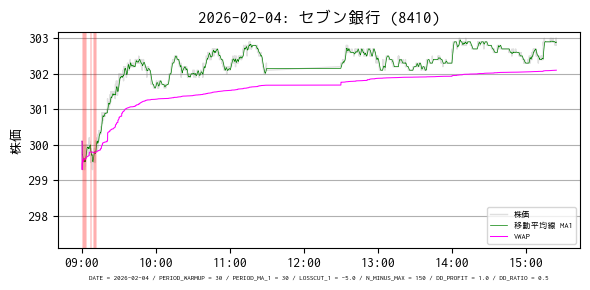

In [25]:
n = 1

if n == 1:
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.grid(axis="y")
else:
    fig = plt.figure(figsize=(6, 8))
    ax = dict()
    gs = fig.add_gridspec(
        n,
        1,
        wspace=0.0,
        hspace=0.0,
        height_ratios=[2 if i == 0 else 1 for i in range(n)],
    )
    for i, axis in enumerate(gs.subplots(sharex="col")):
        ax[i] = axis
        ax[i].grid(axis="y")

name = get_ticker_name_list([code])[code]
ax.set_title(f"{dict_ts['datetime_str_2']}: {name} ({code})")
ax.plot(df_tech["price"], linewidth=1, color="gray", alpha=0.25, label="株価")
ax.plot(df_tech["ma1"], linewidth=0.5, color="green", label="移動平均線 MA1")
ax.plot(df_tech["vwap"], linewidth=0.75, color="magenta", label="VWAP")
ax.set_xlabel(title_str, fontsize=5)
ax.set_ylabel("株価")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.legend(fontsize=6)

y_open = df_tech.iloc[0]["price"]
rng = y_open * 0.01
y_min, y_max = ax.get_ylim()
if y_open - rng < y_min:
    y_min = y_open - rng
if y_max < y_open + rng:
    y_max = y_open + rng
ax.set_ylim(y_min, y_max)

list_cross = df_tech[df_tech["cross1"] != 0].index
print(f"# of cross: {len(list_cross)}")
for t in list_cross:
    ax.axvline(x=t, color="red", linestyle="solid", linewidth=0.25)

# plt.suptitle(title_str, fontsize=5)
plt.tight_layout()
# plt.subplots_adjust(top=0.89)
output = os.path.join(output_dir, f"{code}_trend_technical.png")
print(output)
plt.savefig(output)
plt.show()